In [4]:
import pandas as pd
import datetime as dt
import numpy as np


In [5]:
# importing the data
df = pd.read_csv("C:\\Users\\hp\\Downloads\\rfm.csv")
df.head()


,Unnamed: 0,Order Date,Ship Date,CustomerName,Recency,Frequency,Quantity,Monetary,R_rank,F_rank,Sales,R_rank_norm,F_rank_norm,M_rank_norm,RFM_Score,Customer_segment
0,0,20-06-2023,26-06-2023,Aaron Bergman,16.0,89,5,120359.56970,397.5,770.5,713,50.994227,96.796482,96.796482,89.926144,High Value Customer
1,1,06-06-2023,09-06-2023,Aaron Hawkins,12.0,56,15,102027.89570,486.5,221.5,637,62.411802,27.826633,27.826633,33.014409,Low value Customer
2,2,04-02-2023,11-02-2023,Aaron Smayling,23.0,60,9,64406.23580,298.0,308.0,309,38.229634,38.693467,38.693467,38.623892,Low value Customer
3,3,28-01-2023,31-01-2023,Adam Bellavance,35.0,68,7,109573.00940,173.0,495.0,679,22.193714,62.185930,62.185930,56.187097,Medium Value Customer
4,4,22-12-2023,25-12-2023,Adam Hart,2.0,84,2,91431.54582,699.0,734.5,569,89.672867,92.273869,92.273869,91.883719,High Value Customer


# Calculating Recency

In [15]:
# Convert 'LastPurchaseDate' to datetime format
df_recency['LastPurchaseDate'] = pd.to_datetime(df_recency['LastPurchaseDate'], errors='coerce')

# Ensure 'recent_date' is also a datetime
recent_date = pd.to_datetime(df_recency['LastPurchaseDate'].max())

# Calculate 'Recency' as the difference in days
df_recency['Recency'] = (recent_date - df_recency['LastPurchaseDate']).dt.days

df_recency.head()

C:\Users\hp\AppData\Local\Temp\ipykernel_24640\2973827686.py:2: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_recency['LastPurchaseDate'] = pd.to_datetime(df_recency['LastPurchaseDate'], errors='coerce')


,CustomerName,LastPurchaseDate,Recency
0,Aaron Bergman,2023-06-20,194
1,Aaron Hawkins,2023-06-06,208
2,Aaron Smayling,2023-02-04,330
3,Adam Bellavance,2023-01-28,337
4,Adam Hart,2023-12-22,9


# Calculating Frequency

In [16]:
frequency_df = df.drop_duplicates().groupby(
    by=['CustomerName'], as_index=False)['Order Date'].count()
frequency_df.columns = ['CustomerName', 'Frequency']
frequency_df.head()


,CustomerName,Frequency
0,Aaron Bergman,1
1,Aaron Hawkins,1
2,Aaron Smayling,1
3,Adam Bellavance,1
4,Adam Hart,1


# Calculating Monetary Value

In [17]:
df['Total'] = df['Sales']*df['Quantity']
monetary_df = df.groupby(by='CustomerName', as_index=False)['Total'].sum()
monetary_df.columns = ['CustomerName', 'Monetary']
monetary_df.head()


,CustomerName,Monetary
0,Aaron Bergman,3565
1,Aaron Hawkins,9555
2,Aaron Smayling,2781
3,Adam Bellavance,4753
4,Adam Hart,1138


# Merging all three columns in one dataframe

In [18]:
rf_df = df_recency.merge(frequency_df, on='CustomerName')
rfm_df = rf_df.merge(monetary_df, on='CustomerName').drop(
	columns='LastPurchaseDate')
rfm_df.head()


,CustomerName,Recency,Frequency,Monetary
0,Aaron Bergman,194,1,3565
1,Aaron Hawkins,208,1,9555
2,Aaron Smayling,330,1,2781
3,Adam Bellavance,337,1,4753
4,Adam Hart,9,1,1138


# Ranking Customer’s based upon their recency, frequency, and monetary score


In [19]:
rfm_df['R_rank'] = rfm_df['Recency'].rank(ascending=False)
rfm_df['F_rank'] = rfm_df['Frequency'].rank(ascending=True)
rfm_df['M_rank'] = rfm_df['Monetary'].rank(ascending=True)

# normalizing the rank of the customers
rfm_df['R_rank_norm'] = (rfm_df['R_rank']/rfm_df['R_rank'].max())*100
rfm_df['F_rank_norm'] = (rfm_df['F_rank']/rfm_df['F_rank'].max())*100
rfm_df['M_rank_norm'] = (rfm_df['F_rank']/rfm_df['M_rank'].max())*100

rfm_df.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)

rfm_df.head()


,CustomerName,Recency,Frequency,Monetary,R_rank_norm,F_rank_norm,M_rank_norm
0,Aaron Bergman,194,1,3565,50.659962,100.0,50.062814
1,Aaron Hawkins,208,1,9555,47.328724,100.0,50.062814
2,Aaron Smayling,330,1,2781,10.119422,100.0,50.062814
3,Adam Bellavance,337,1,4753,7.416719,100.0,50.062814
4,Adam Hart,9,1,1138,97.611565,100.0,50.062814


# Calculating RFM score


In [20]:
rfm_df['RFM_Score'] = 0.15*rfm_df['R_rank_norm']+0.28 * \
	rfm_df['F_rank_norm']+0.57*rfm_df['M_rank_norm']
rfm_df['RFM_Score'] *= 0.05
rfm_df = rfm_df.round(2)
rfm_df[['CustomerName', 'RFM_Score']].head(7)


,CustomerName,RFM_Score
0,Aaron Bergman,3.21
1,Aaron Hawkins,3.18
2,Aaron Smayling,2.90
3,Adam Bellavance,2.88
4,Adam Hart,3.56
5,Adam Shillingsburg,3.57
6,Adrian Barton,3.02


# Rating Customer based upon the RFM score

In [21]:
rfm_df["Customer_segment"] = np.where(rfm_df['RFM_Score'] >
                                      4.5, "Top Customers", 
                                      (np.where(
                                        rfm_df['RFM_Score'] > 4,
                                        "High value Customer",
                                        (np.where(
    rfm_df['RFM_Score'] > 3,
                             "Medium Value Customer",
                             np.where(rfm_df['RFM_Score'] > 1.6, 
                            'Low Value Customers', 'Lost Customers'))))))
rfm_df[['CustomerName', 'RFM_Score', 'Customer_segment']].head(20)

,CustomerName,RFM_Score,Customer_segment
0,Aaron Bergman,3.21,Medium Value Customer
1,Aaron Hawkins,3.18,Medium Value Customer
2,Aaron Smayling,2.90,Low Value Customers
3,Adam Bellavance,2.88,Low Value Customers
4,Adam Hart,3.56,Medium Value Customer
5,Adam Shillingsburg,3.57,Medium Value Customer
6,Adrian Barton,3.02,Medium Value Customer
7,Adrian Hane,2.92,Low Value Customers
8,Adrian Shami,2.89,Low Value Customers
9,Aimee Bixby,2.99,Low Value Customers


# Visualizing the customer segments

In [22]:
import matplotlib.pyplot as plt


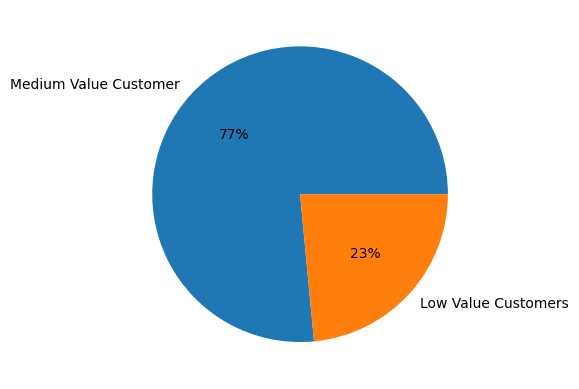

In [23]:
plt.pie(rfm_df.Customer_segment.value_counts(),
        labels=rfm_df.Customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()